In [1]:
import pandas as pd
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('../Data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.columns=['tweet_text', 'product/company', 'sentiment']
df.head()

,tweet_text,product/company,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df['sentiment'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [5]:
df['product/company'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product/company, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       9092 non-null   object
 1   product/company  3291 non-null   object
 2   sentiment        9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Data Cleaning and Preprocessing

### Data Cleaning

In [7]:
clean_df = df.copy()

In [8]:
clean_df.isnull().sum()

tweet_text            1
product/company    5802
sentiment             0
dtype: int64

In [9]:
clean_df = clean_df.dropna(subset =['tweet_text'])

In [10]:
clean_df = clean_df[['tweet_text', 'sentiment']]

In [11]:
clean_df.isnull().sum()

tweet_text    0
sentiment     0
dtype: int64

In [12]:
clean_df['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [13]:
clean_df = clean_df[clean_df['sentiment'] != "I can't tell"].reset_index(drop=True)

In [14]:
clean_df['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: sentiment, dtype: int64

In [15]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  8936 non-null   object
 1   sentiment   8936 non-null   object
dtypes: object(2)
memory usage: 139.8+ KB


In [16]:
clean_df.head()

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [ ]:
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text) # Remove URLS
    text = re.sub(r"@\w+", "", text) # Remove mentions/usernames
    text = re.sub(r'#\w+', '', text) # Remove the '#' symbol and remain with the hashtag text
    text = re.sub(r"[^a-z\s]", "", text) # Remove punctuation, numbers, emojis, symbols
    return text 

In [18]:
clean_df['clean_tweet_text'] = clean_df['tweet_text'].apply(clean_tweet)
clean_df.head()

,tweet_text,sentiment,clean_tweet_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,i have a g iphone after hrs tweeting at rise...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,know about awesome ipadiphone app that youl...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,can not wait for ipad also they should sale ...
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,i hope this years festival isnt as crashy as ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,great stuff on fri sxsw marissa mayer google ...


#### preprocessing

In [19]:
basic_token_pattern = r"[a-zA-Z]+(?:'[a-z]+)?"
tokenizer = RegexpTokenizer(basic_token_pattern)
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [20]:
prepocessed_tweets = []
for tweet in clean_df['clean_tweet_text']:
    tokens = tokenizer.tokenize(tweet)
    stopped_tokens = [word for word in tokens if word not in stopwords_list]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens]
    prepocessed_tweets.append(' '.join(lemmatized_tokens))
clean_df['preprocessed_tweet'] = prepocessed_tweets
clean_df.head()

,tweet_text,sentiment,clean_tweet_text,preprocessed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,i have a g iphone after hrs tweeting at rise...,g iphone hr tweeting riseaustin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,know about awesome ipadiphone app that youl...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,can not wait for ipad also they should sale ...,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,i hope this years festival isnt as crashy as ...,hope year festival isnt crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,great stuff on fri sxsw marissa mayer google ...,great stuff fri sxsw marissa mayer google tim ...


## EDA (FreqDist and WordCloud)

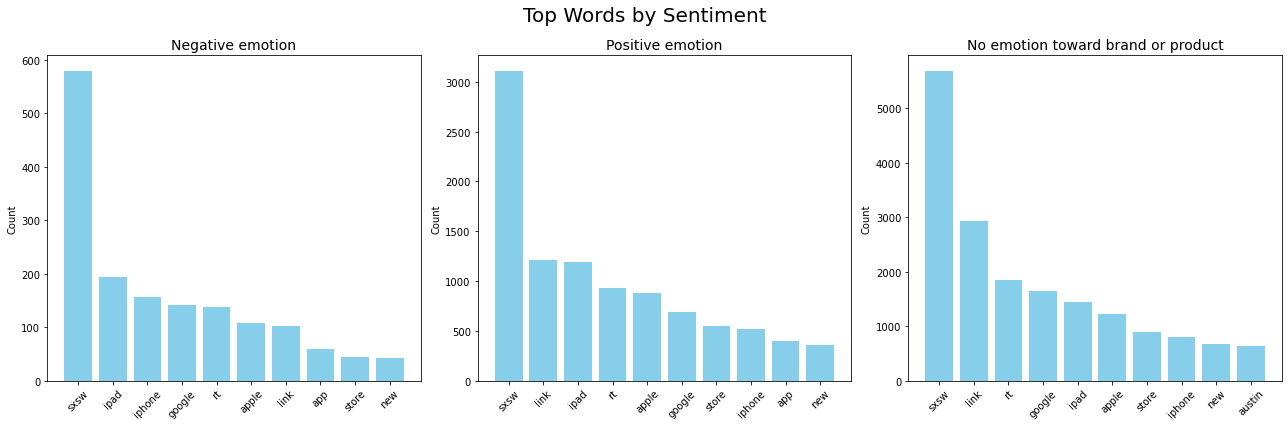

In [21]:
# Ensure each tweet is a list of words
clean_df['tokens'] = clean_df['preprocessed_tweet'].apply(lambda x: x.split())

# Get the unique sentiment labels
sentiment_labels = clean_df['sentiment'].unique()

# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.set_tight_layout(True)

# Plot top 10 words for each sentiment
for idx, sentiment in enumerate(sentiment_labels):
    # Combine all words for this sentiment
    all_words = [word for tokens in clean_df[clean_df['sentiment'] == sentiment]['tokens'] for word in tokens]
    freq_dist = FreqDist(all_words)
    top_words = freq_dist.most_common(10)
    
    # Unpack for plotting
    words, counts = zip(*top_words)
    
    axes[idx].bar(words, counts, color='skyblue')
    axes[idx].set_title(sentiment, fontsize=14)
    axes[idx].set_ylabel("Count")
    axes[idx].tick_params(axis="x", rotation=45)

fig.suptitle("Top Words by Sentiment", fontsize=20)
plt.show()

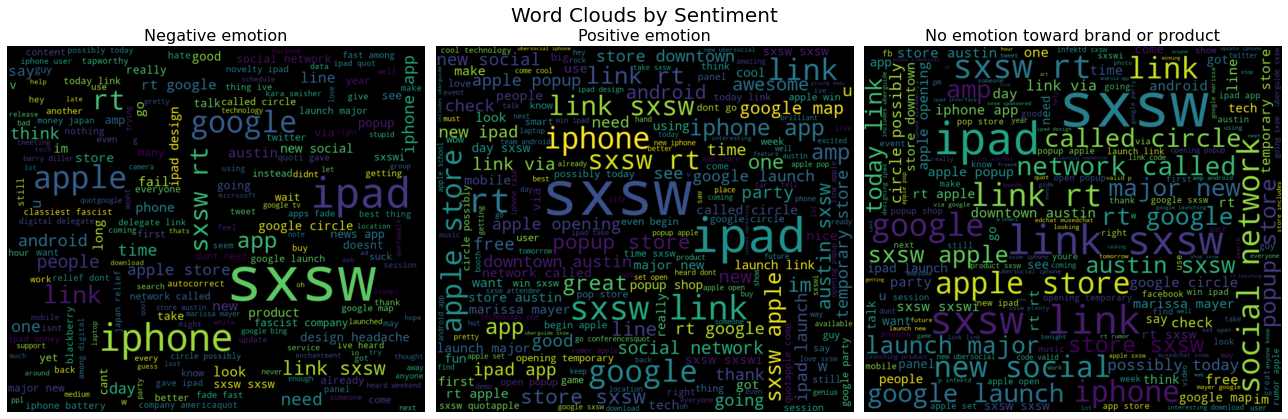

In [22]:
# Make sure tokens exist
clean_df['tokens'] = clean_df['preprocessed_tweet'].apply(lambda x: x.split())

# Get unique sentiments
sentiment_labels = clean_df['sentiment'].unique()

# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.set_tight_layout(True)

# Generate WordCloud for each sentiment
for idx, sentiment in enumerate(sentiment_labels):
    # Combine all words into a single string
    all_words = ' '.join(
        word for tokens in clean_df[clean_df['sentiment'] == sentiment]['tokens'] for word in tokens
    )
    
    # Create WordCloud
    wordcloud = WordCloud(
        width=800,
        height=700,
        max_font_size=120
        ).generate(all_words)
    
    # Plot in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(sentiment, fontsize=16)

fig.suptitle("Word Clouds by Sentiment", fontsize=20)
plt.show()

## Modeling and Evaluation

### label/target preparation

#### Binary classification (Positive and Negative)

#### Multiclass Classification (Positive, Negatve and Neutral)